In [12]:
#Loading all required libraries and dependencies
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os
import numpy as np

import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

import cv2
import pandas as pd
import random
import ntpath

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [13]:
#6 columns - display first five rows
datadir = 'data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None) #display full width of columns
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_382.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_382.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_382.jpg,0.0,0.0,0,0.000079
1,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_526.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_526.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_526.jpg,0.0,0.0,0,0.000082
2,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_669.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_669.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_669.jpg,0.0,0.0,0,0.000078
3,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_802.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_802.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_802.jpg,0.0,0.0,0,0.000078
4,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_937.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_937.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_937.jpg,0.0,0.0,0,0.000080


In [14]:
#Remove prefix part through the dataset
def path_leaf(path):
    head, tail = ntpath.split(path) #C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_382.jpg -> center_2019_07_22_20_38_15_382.jpg
    return tail
#Removing path of images
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_07_22_20_38_15_382.jpg,left_2019_07_22_20_38_15_382.jpg,right_2019_07_22_20_38_15_382.jpg,0.0,0.0,0,0.000079
1,center_2019_07_22_20_38_15_526.jpg,left_2019_07_22_20_38_15_526.jpg,right_2019_07_22_20_38_15_526.jpg,0.0,0.0,0,0.000082
2,center_2019_07_22_20_38_15_669.jpg,left_2019_07_22_20_38_15_669.jpg,right_2019_07_22_20_38_15_669.jpg,0.0,0.0,0,0.000078
3,center_2019_07_22_20_38_15_802.jpg,left_2019_07_22_20_38_15_802.jpg,right_2019_07_22_20_38_15_802.jpg,0.0,0.0,0,0.000078
4,center_2019_07_22_20_38_15_937.jpg,left_2019_07_22_20_38_15_937.jpg,right_2019_07_22_20_38_15_937.jpg,0.0,0.0,0,0.000080


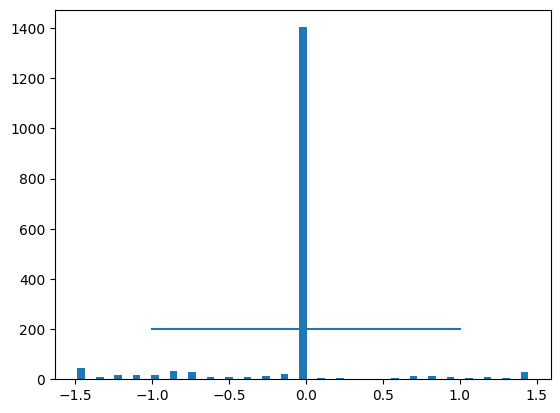

In [17]:
#Plot distribution
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = bins[:-1] + bins[1:] * 0.5  # center the bins to 0

#Plot
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Total data: 1743
Removed: 1203
Remaining: 540


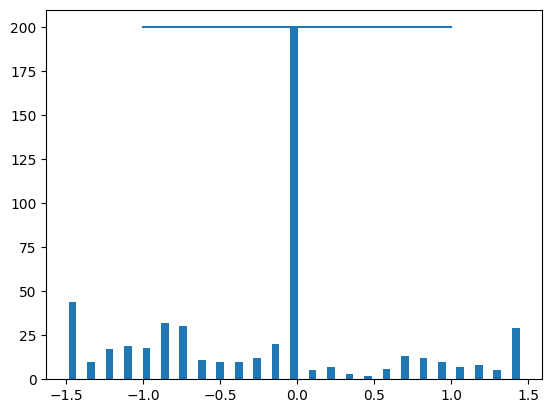

In [18]:
#Remove data
print('Total data: {0}'.format(len(data)))

## Make list of indices to remove
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    steering_angle = data['steering'][i]
    if steering_angle >= bins[j] and steering_angle <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
  
## Remove from extras from list
data.drop(data.index[remove_list], inplace=True)
print('Removed: {0}'.format(len(remove_list)))
print('Remaining: {0}'.format(len(data)))

## Plot
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [23]:
#Load all images, steering wheel angles and throttle values
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        print("IND")
        print(indexed_data)
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

IND
center      center_2019_07_22_20_38_15_382.jpg
left          left_2019_07_22_20_38_15_382.jpg
right        right_2019_07_22_20_38_15_382.jpg
steering                                   0.0
throttle                                   0.0
reverse                                      0
speed                                 0.000079
Name: 0, dtype: object
IND
center      center_2019_07_22_20_38_15_526.jpg
left          left_2019_07_22_20_38_15_526.jpg
right        right_2019_07_22_20_38_15_526.jpg
steering                                   0.0
throttle                                   0.0
reverse                                      0
speed                                 0.000082
Name: 1, dtype: object
IND
center      center_2019_07_22_20_38_15_669.jpg
left          left_2019_07_22_20_38_15_669.jpg
right        right_2019_07_22_20_38_15_669.jpg
steering                                   0.0
throttle                                   0.0
reverse                                      0
sp

In [24]:
#Data gets splitted using 80% for training and 20% for validation
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))

Text(0.5, 1.0, 'Preprocessed Image')

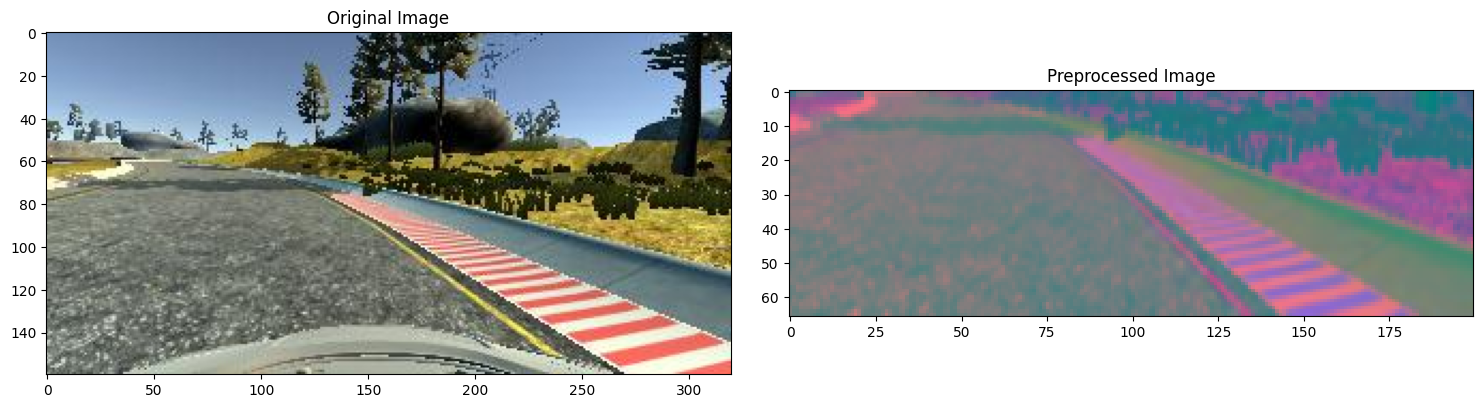

In [26]:
#Image processing - Takes part of the image and returns processed image
def img_preprocess(img):
    img = npimg.imread(img)
    # Crop image to remove unnecessary features
    img = img[60:135,:,:]
    # Change to YUV image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    # Change to YUV image
    img = cv2.GaussianBlur(img, (3, 3), 0)
    # Decrease size for easier processing
    img = cv2.resize(img, (200, 66))
    # Normalize values
    img = img / 255
    # Get an image
    return img

image = image_paths[510]
original_image = npimg.imread(image)
preprocessed_image = img_preprocess(image)

## Compare original and preprocessed image
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [ ]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))
